# Фаза 2 • Неделя 8 • Вторник
## Нейронные сети
### 🔥 PyTorch: Fashion MNIST

В этом задании необходимо классифицировать изображения датасета Fashion MNIST - аналогичного набору рукописных цифр. Для решения этой задачи не нужна сложная нейросеть, 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import torchutils as tu
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120
import mplcyberpunk
plt.style.use("cyberpunk")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train_loader = DataLoader(
    FashionMNIST(
        root='data/', 
        train=True,
        download=True,
        transform=ToTensor()
    ),
    batch_size=64

)
valid_loader = DataLoader(
    FashionMNIST(
        root='data/', 
        train=False,
        download=True,
        transform=ToTensor()
    ),
    batch_size=64
)

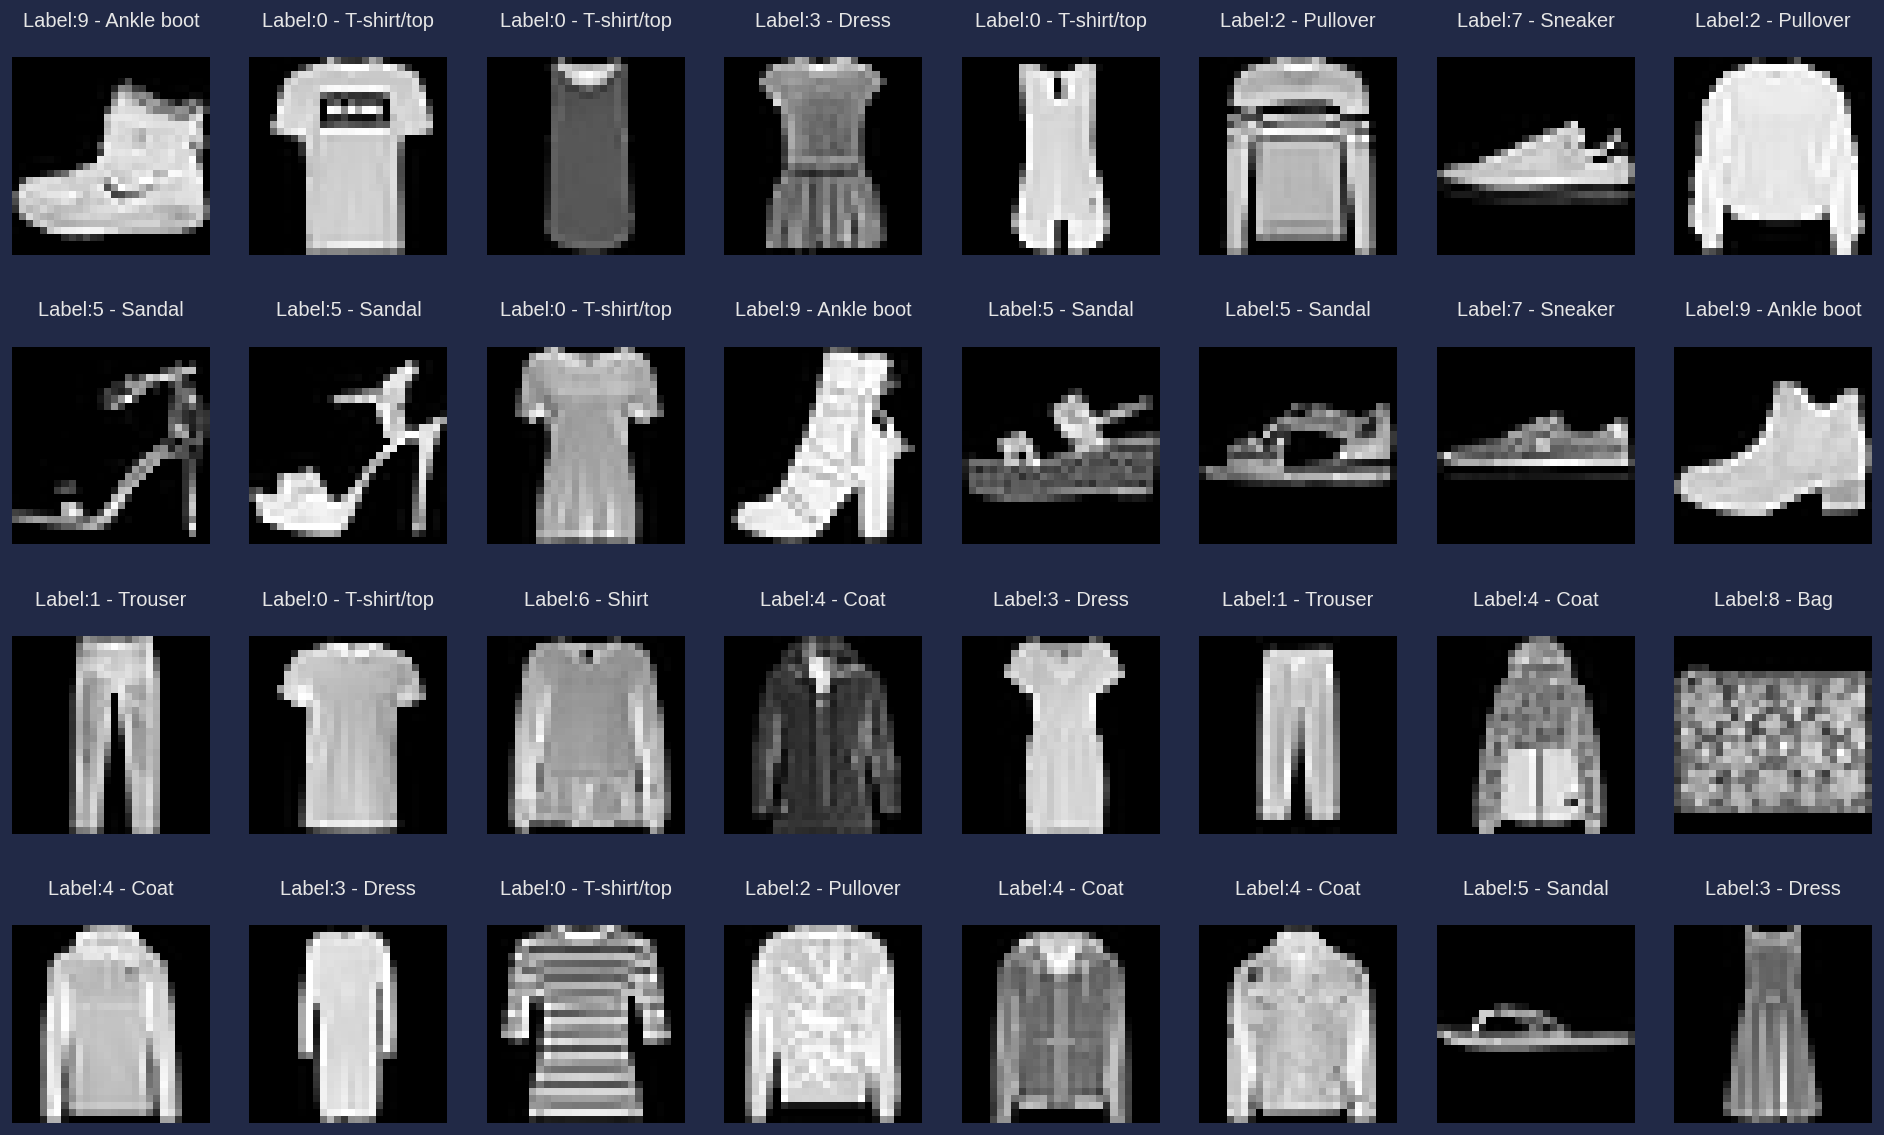

In [3]:
def get_batch_from_loader(loader):
    batch, labels = next(iter(loader))
    return batch, labels

# распечатаем произвольную картинку
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
batch, labels = get_batch_from_loader(train_loader)
for i, plot in enumerate(ax):
    plot.set_title(f'Label:{labels[i]} - {train_loader.dataset.classes[labels[i]]}')
    plot.matshow(batch[i][0, :, :], cmap='gray')
    plot.axis('off')

In [4]:
train_loader.dataset.classes
train_loader.dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [5]:
for data, labels in train_loader:
    print(data.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


1. Задай класс модели: начни с самого простого однослойного персептрона. 

In [6]:
# Задаем класс модели
class TorchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flat = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 10)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        #x = self.flat(x)
        x_first_out = F.relu(self.fc1(x))
        x_second_out = self.dropout(F.relu(self.fc2(x_first_out)))
        x_third_out = self.dropout(F.relu(self.fc3(x_second_out)))
        x_fourd_out = self.dropout(F.relu(self.fc4(x_third_out)))
        x_final = self.fc5(x_fourd_out)

        return x_final

2. С помощью `tu.get_model_summary` распечатай структуру модели

In [7]:
model = TorchClassifier()
tu.get_model_summary(model, torch.randn(64, 28, 28))

Layer         Kernel      Output     Params         FLOPs
0_fc1       [784, 128]   [64, 128]   100,480   12,836,864
1_fc2        [128, 64]    [64, 64]     8,256    1,044,480
2_dropout            -    [64, 64]         0            0
3_fc3         [64, 32]    [64, 32]     2,080      260,096
4_dropout            -    [64, 32]         0            0
5_fc4         [32, 16]    [64, 16]       528       64,512
6_dropout            -    [64, 16]         0            0
7_fc5         [16, 10]    [64, 10]       170       19,840
Total params: 111,514
Trainable params: 111,514
Non-trainable params: 0
Total FLOPs: 14,225,792 / 14.23 MFLOPs
---------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.18
Params size (MB): 0.43
Estimated Total Size (MB): 0.79


3. Задай оптимизатор и функцию потерь

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

4. Реализуй цикл обучения: функция должна возвращать историю лосса на обучении и валидации, а также значение метрики `accuracy`. 

In [ ]:
def fit_model(epochs: int, model: nn.Module, optimizer: torch.optim.Optimizer) -> tuple[list, ...]:

    train_losses = []
    valid_losses = []
    train_metrics = []
    valid_metrics = []
    
    for epoch in range(epochs):

        model.train()
        train_loss_iter = []
        train_metric_iter = []
    
        for data, labels in train_loader:
            
            data = data.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(data)

            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_iter.append(loss.item())
            train_metric_iter.append((y_pred.argmax(axis=1) == labels.to(DEVICE)).cpu().numpy().mean())

        model.eval()

        valid_loss_iter = []
        valid_metric_iter = []

        for data, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(data.to(DEVICE))
            loss = criterion(y_pred, labels.to(DEVICE))


            valid_loss_iter.append(loss.item())
            valid_metric_iter.append((y_pred.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())

        train_losses.append(np.mean(train_loss_iter))
        valid_losses.append(np.mean(valid_loss_iter))

        train_metrics.append(np.mean(train_metric_iter))
        valid_metrics.append(np.mean(valid_metric_iter))

        if epoch % 1 == 0:
            print(f'Epoch {epoch} finished: train_loss={train_losses[-1]:.3f}, valid_loss={valid_losses[-1]:.3f}')
            print(f'Epoch {epoch} finished: train_metric={train_metrics[-1]:.3f}, valid_metric={valid_metrics[-1]:.3f}')

    return train_losses, valid_losses, train_metrics, valid_metrics

In [10]:
history = None
model.to(DEVICE)

TorchClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [11]:
train_losses, valid_losses, train_metric, valid_metric = fit_model(20, model, optimizer)

Epoch 0 finished: train_loss=1.174, valid_loss=0.773
Epoch 0 finished: train_metric=0.523, valid_metric=0.691
Epoch 1 finished: train_loss=0.800, valid_loss=0.609
Epoch 1 finished: train_metric=0.698, valid_metric=0.786
Epoch 2 finished: train_loss=0.668, valid_loss=0.524
Epoch 2 finished: train_metric=0.761, valid_metric=0.813
Epoch 3 finished: train_loss=0.584, valid_loss=0.456
Epoch 3 finished: train_metric=0.799, valid_metric=0.839
Epoch 4 finished: train_loss=0.536, valid_loss=0.428
Epoch 4 finished: train_metric=0.819, valid_metric=0.848
Epoch 5 finished: train_loss=0.503, valid_loss=0.428
Epoch 5 finished: train_metric=0.832, valid_metric=0.855
Epoch 6 finished: train_loss=0.478, valid_loss=0.437
Epoch 6 finished: train_metric=0.838, valid_metric=0.855
Epoch 7 finished: train_loss=0.465, valid_loss=0.421
Epoch 7 finished: train_metric=0.844, valid_metric=0.860
Epoch 8 finished: train_loss=0.448, valid_loss=0.401
Epoch 8 finished: train_metric=0.848, valid_metric=0.861
Epoch 9 fi

Построй кривые обучения: функции потерь и метрики на обучении и валидации

In [12]:
def plot_loss_metrics(tl: list, vl: list, tm: list, vm: list):
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(tl, label='Train loss')
    ax[0].plot(vl, label='Valid Loss')
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[0].set_ylim((0, max(tl+vl)+.1))

    ax[1].plot(tm, label='Train accuracy')
    ax[1].plot(vm, label='Valid accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')
    ax[1].set_ylim((0, max(tm+vm)+.1))

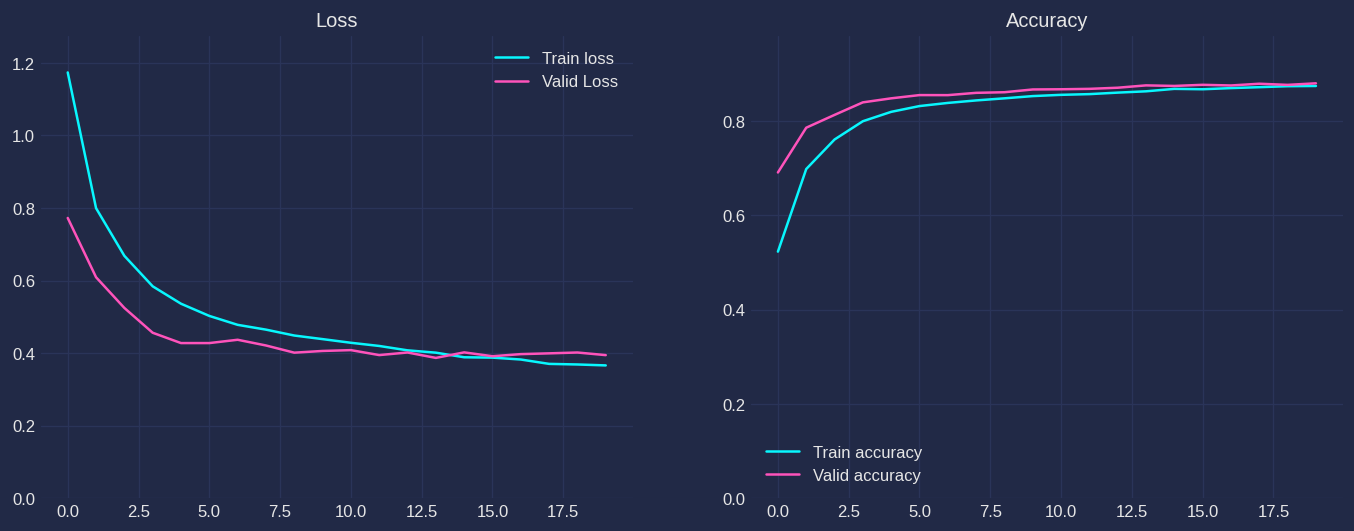

In [13]:
plot_loss_metrics(train_losses, valid_losses, train_metric, valid_metric)

5. Попробуй создать еще 2 модели с разной архитектурой и проанализируй качество ыих решений. Для этого распечатай графики лосса и метрики на выборках. На что повлияло число нейронов и слоев? 

    ❗️ Самые сложные модели должны достигать качества >80% на валидационной части выборки.

    ❗️ При создании новой модели **обязательно** нужно создать новый оптимизатор, в который будут передаваться параметры новой модели. 

In [18]:
train_loader.dataset.classes
train_loader.dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

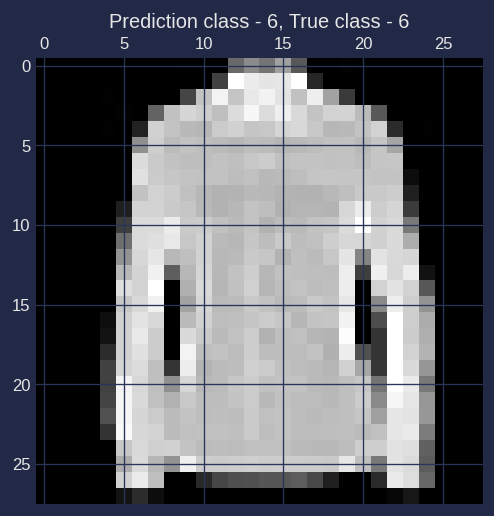

In [25]:
for data, target in valid_loader:
    index = 26
    test_sample = data[index].unsqueeze(0).to(DEVICE)
    test_target = target[index]
    prediction = model(test_sample).argmax().item()

    plt.matshow(test_sample.cpu().squeeze(), cmap='grey')
    plt.title(f'Prediction class - {prediction}, True class - {test_target.item()}');
    
    break

In [31]:
# code
class TorchClassifier1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        x = self.flat(x)
        x_first_out = F.relu(self.fc1(x))
        x_second_out = self.dropout(F.relu(self.fc2(x_first_out)))
        x_final = self.fc3(x_second_out)
        
        return x_final
    

class TorchClassifier2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.fc0 = nn.Linear(784, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.flat(x)
        x_null_out = F.relu(self.fc0(x))
        x_first_out = self.dropout(F.relu(self.fc1(x_null_out)))
        x_second_out = self.dropout(F.relu(self.fc2(x_first_out)))
        x_final = self.fc3(x_second_out)
        
        return x_final

In [29]:
model1 = TorchClassifier1()
model1.to(DEVICE);
optimizer = torch.optim.Adam(model1.parameters(), lr = 0.001)
train_losses, valid_losses, train_metric, valid_metric = fit_model(20, model1, optimizer)

Epoch 0 finished: train_loss=1.524, valid_loss=0.766
Epoch 0 finished: train_metric=0.410, valid_metric=0.773
Epoch 1 finished: train_loss=1.266, valid_loss=0.645
Epoch 1 finished: train_metric=0.499, valid_metric=0.797
Epoch 2 finished: train_loss=1.194, valid_loss=0.591
Epoch 2 finished: train_metric=0.526, valid_metric=0.813
Epoch 3 finished: train_loss=1.132, valid_loss=0.557
Epoch 3 finished: train_metric=0.556, valid_metric=0.822
Epoch 4 finished: train_loss=1.099, valid_loss=0.551
Epoch 4 finished: train_metric=0.568, valid_metric=0.832
Epoch 5 finished: train_loss=1.075, valid_loss=0.544
Epoch 5 finished: train_metric=0.585, valid_metric=0.830
Epoch 6 finished: train_loss=1.058, valid_loss=0.534
Epoch 6 finished: train_metric=0.595, valid_metric=0.830
Epoch 7 finished: train_loss=1.041, valid_loss=0.534
Epoch 7 finished: train_metric=0.601, valid_metric=0.829
Epoch 8 finished: train_loss=1.040, valid_loss=0.513
Epoch 8 finished: train_metric=0.605, valid_metric=0.833
Epoch 9 fi

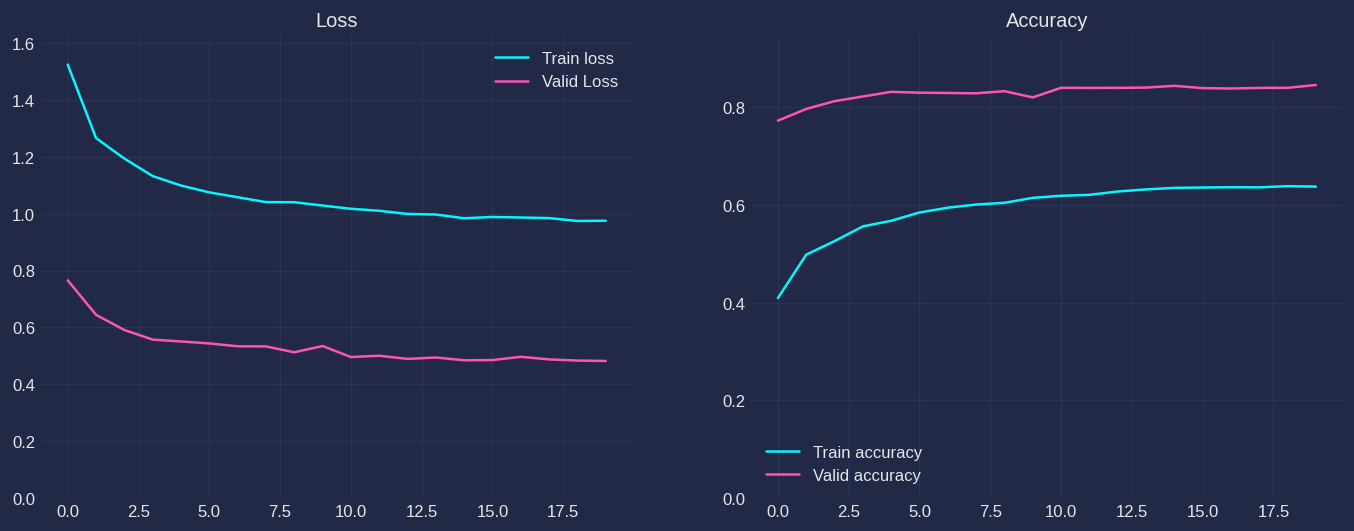

In [30]:
plot_loss_metrics(train_losses, valid_losses, train_metric, valid_metric)

In [32]:
model2 = TorchClassifier2()
model2.to(DEVICE);
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.001)
train_losses, valid_losses, train_metric, valid_metric = fit_model(20, model2, optimizer)

Epoch 0 finished: train_loss=1.298, valid_loss=0.718
Epoch 0 finished: train_metric=0.502, valid_metric=0.695
Epoch 1 finished: train_loss=0.984, valid_loss=0.637
Epoch 1 finished: train_metric=0.612, valid_metric=0.736
Epoch 2 finished: train_loss=0.898, valid_loss=0.575
Epoch 2 finished: train_metric=0.652, valid_metric=0.791
Epoch 3 finished: train_loss=0.848, valid_loss=0.548
Epoch 3 finished: train_metric=0.680, valid_metric=0.803
Epoch 4 finished: train_loss=0.805, valid_loss=0.528
Epoch 4 finished: train_metric=0.699, valid_metric=0.808
Epoch 5 finished: train_loss=0.782, valid_loss=0.513
Epoch 5 finished: train_metric=0.712, valid_metric=0.816
Epoch 6 finished: train_loss=0.757, valid_loss=0.511
Epoch 6 finished: train_metric=0.722, valid_metric=0.827
Epoch 7 finished: train_loss=0.737, valid_loss=0.492
Epoch 7 finished: train_metric=0.729, valid_metric=0.840
Epoch 8 finished: train_loss=0.713, valid_loss=0.485
Epoch 8 finished: train_metric=0.738, valid_metric=0.844
Epoch 9 fi

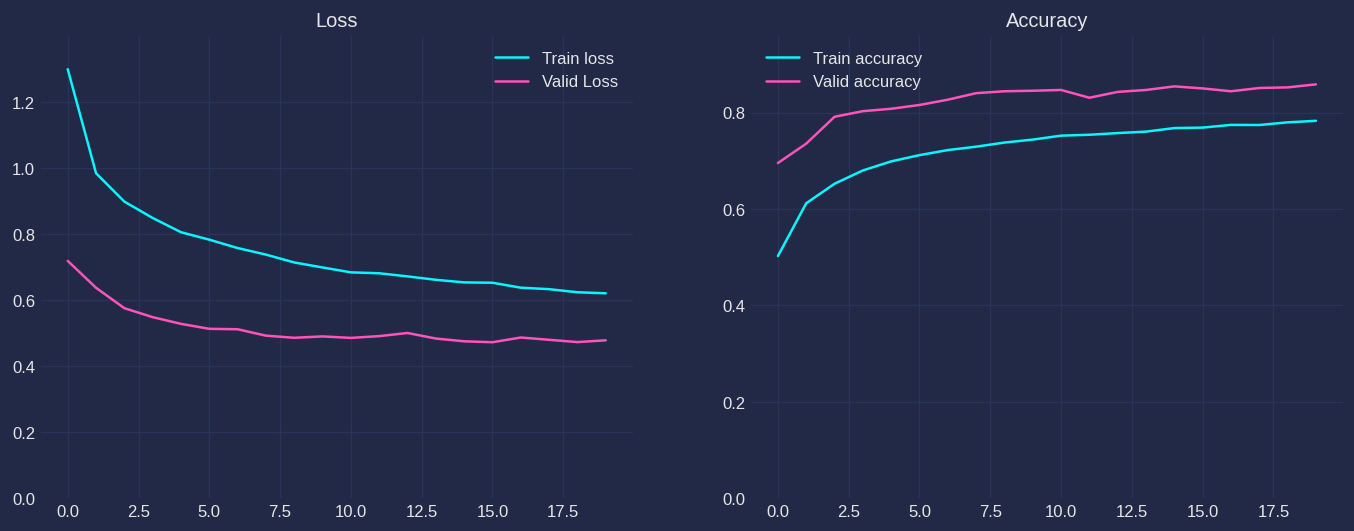

In [33]:
plot_loss_metrics(train_losses, valid_losses, train_metric, valid_metric)

# ❓

Для чего при обучении применяется слой `Dropout`?

> Предотвращает преобучение. Позволяет не "запоминать" данные, а пытаться их определять по каким-то обобщенным признаками

6. Обучи лучшую модель 3 раза с тремя разными оптимизаторами: `SGD`, `Adagrad`, `Adadelta`. Визуализируй график лосса и сравни, как изменяется значение функции потерь в зависимости от используемого алгоритма оптимизации. Какой алгоритм самый лучший?

В результате должен получиться **примерно** такой график: 

![](aux/imgs/08-02-res.png)

In [ ]:
optimizers = {
    'SGD': optim.SGD,
    'Adagrad': optim.Adagrad,
    'Adadelta': optim.Adadelta
}

# Словарь для сохранения лосса
losses = {}

# Обучаем модель с каждым оптимизатором и сохраняем лосс
for opt_name, opt_class in optimizers.items():
    optimizer = opt_class(TorchClassifier().parameters(), lr=0.001)
    train_losses, valid_losses = model(optimizer, train_loader, valid_loader, epochs=10)
    losses[opt_name] = {'train': train_losses, 'valid': valid_losses}

# Визуализируем графики
plt.figure(figsize=(12, 6))
for opt_name, loss_values in losses.items():
    plt.plot(loss_values['train'], label=f'{opt_name} - Train Loss')
    plt.plot(loss_values['valid'], label=f'{opt_name} - Valid Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss by Optimizer')
plt.show()

In [13]:
# code
model = TorchClassifier()
model.to(DEVICE);
optimizer_adam = torch.optim.Adam(model.parameters(), lr = 0.001)
train_losses_adam, valid_losses_adam, train_metric_adam, valid_metric_adam = fit_model(25, model, optimizer_adam)

Epoch 0 finished: train_loss=0.996, valid_loss=0.543
Epoch 0 finished: train_metric=0.625, valid_metric=0.791
Epoch 1 finished: train_loss=0.653, valid_loss=0.477
Epoch 1 finished: train_metric=0.762, valid_metric=0.828
Epoch 2 finished: train_loss=0.578, valid_loss=0.442
Epoch 2 finished: train_metric=0.800, valid_metric=0.841
Epoch 3 finished: train_loss=0.538, valid_loss=0.411
Epoch 3 finished: train_metric=0.814, valid_metric=0.858
Epoch 4 finished: train_loss=0.504, valid_loss=0.403
Epoch 4 finished: train_metric=0.829, valid_metric=0.857
Epoch 5 finished: train_loss=0.478, valid_loss=0.412
Epoch 5 finished: train_metric=0.835, valid_metric=0.855
Epoch 6 finished: train_loss=0.466, valid_loss=0.405
Epoch 6 finished: train_metric=0.841, valid_metric=0.865
Epoch 7 finished: train_loss=0.447, valid_loss=0.392
Epoch 7 finished: train_metric=0.846, valid_metric=0.866
Epoch 8 finished: train_loss=0.443, valid_loss=0.389
Epoch 8 finished: train_metric=0.847, valid_metric=0.868
Epoch 9 fi

In [20]:
model = TorchClassifier()
model.to(DEVICE);
optimizer_adag = torch.optim.Adagrad(model.parameters(), lr = 0.01)
train_losses_adag, valid_losses_adag, train_metric_adag, valid_metric_adag = fit_model(25, model, optimizer_adag)

Epoch 0 finished: train_loss=1.047, valid_loss=0.626
Epoch 0 finished: train_metric=0.607, valid_metric=0.774
Epoch 1 finished: train_loss=0.748, valid_loss=0.539
Epoch 1 finished: train_metric=0.730, valid_metric=0.798
Epoch 2 finished: train_loss=0.678, valid_loss=0.510
Epoch 2 finished: train_metric=0.755, valid_metric=0.804
Epoch 3 finished: train_loss=0.645, valid_loss=0.499
Epoch 3 finished: train_metric=0.769, valid_metric=0.808
Epoch 4 finished: train_loss=0.620, valid_loss=0.487
Epoch 4 finished: train_metric=0.778, valid_metric=0.811
Epoch 5 finished: train_loss=0.600, valid_loss=0.481
Epoch 5 finished: train_metric=0.784, valid_metric=0.814
Epoch 6 finished: train_loss=0.586, valid_loss=0.475
Epoch 6 finished: train_metric=0.789, valid_metric=0.814
Epoch 7 finished: train_loss=0.572, valid_loss=0.468
Epoch 7 finished: train_metric=0.794, valid_metric=0.819
Epoch 8 finished: train_loss=0.562, valid_loss=0.465
Epoch 8 finished: train_metric=0.798, valid_metric=0.819
Epoch 9 fi

In [31]:
model = TorchClassifier()
model.to(DEVICE);
optimizer_adad = torch.optim.Adadelta(model.parameters(), lr = 0.1)
train_losses_adad, valid_losses_adad, train_metric_adad, valid_metric_adad = fit_model(25, model, optimizer_adad)

Epoch 0 finished: train_loss=1.651, valid_loss=1.098
Epoch 0 finished: train_metric=0.330, valid_metric=0.552
Epoch 1 finished: train_loss=1.139, valid_loss=0.863
Epoch 1 finished: train_metric=0.531, valid_metric=0.665
Epoch 2 finished: train_loss=0.954, valid_loss=0.729
Epoch 2 finished: train_metric=0.622, valid_metric=0.722
Epoch 3 finished: train_loss=0.857, valid_loss=0.661
Epoch 3 finished: train_metric=0.670, valid_metric=0.738
Epoch 4 finished: train_loss=0.793, valid_loss=0.609
Epoch 4 finished: train_metric=0.697, valid_metric=0.759
Epoch 5 finished: train_loss=0.744, valid_loss=0.579
Epoch 5 finished: train_metric=0.716, valid_metric=0.775
Epoch 6 finished: train_loss=0.704, valid_loss=0.559
Epoch 6 finished: train_metric=0.736, valid_metric=0.792
Epoch 7 finished: train_loss=0.679, valid_loss=0.536
Epoch 7 finished: train_metric=0.749, valid_metric=0.813
Epoch 8 finished: train_loss=0.655, valid_loss=0.520
Epoch 8 finished: train_metric=0.760, valid_metric=0.817
Epoch 9 fi

In [41]:
model = TorchClassifier()
model.to(DEVICE);
optimizer_sgd = torch.optim.SGD(model.parameters(), lr = 0.05)
train_losses_sgd, valid_losses_sgd, train_metric_sgd, valid_metric_sgd = fit_model(25, model, optimizer_sgd)

Epoch 0 finished: train_loss=1.646, valid_loss=0.940
Epoch 0 finished: train_metric=0.348, valid_metric=0.605
Epoch 1 finished: train_loss=1.015, valid_loss=0.728
Epoch 1 finished: train_metric=0.597, valid_metric=0.756
Epoch 2 finished: train_loss=0.848, valid_loss=0.626
Epoch 2 finished: train_metric=0.685, valid_metric=0.775
Epoch 3 finished: train_loss=0.769, valid_loss=0.606
Epoch 3 finished: train_metric=0.717, valid_metric=0.783
Epoch 4 finished: train_loss=0.722, valid_loss=0.605
Epoch 4 finished: train_metric=0.735, valid_metric=0.778
Epoch 5 finished: train_loss=0.684, valid_loss=0.572
Epoch 5 finished: train_metric=0.754, valid_metric=0.791
Epoch 6 finished: train_loss=0.652, valid_loss=0.601
Epoch 6 finished: train_metric=0.771, valid_metric=0.773
Epoch 7 finished: train_loss=0.623, valid_loss=0.505
Epoch 7 finished: train_metric=0.784, valid_metric=0.830
Epoch 8 finished: train_loss=0.591, valid_loss=0.499
Epoch 8 finished: train_metric=0.797, valid_metric=0.834
Epoch 9 fi

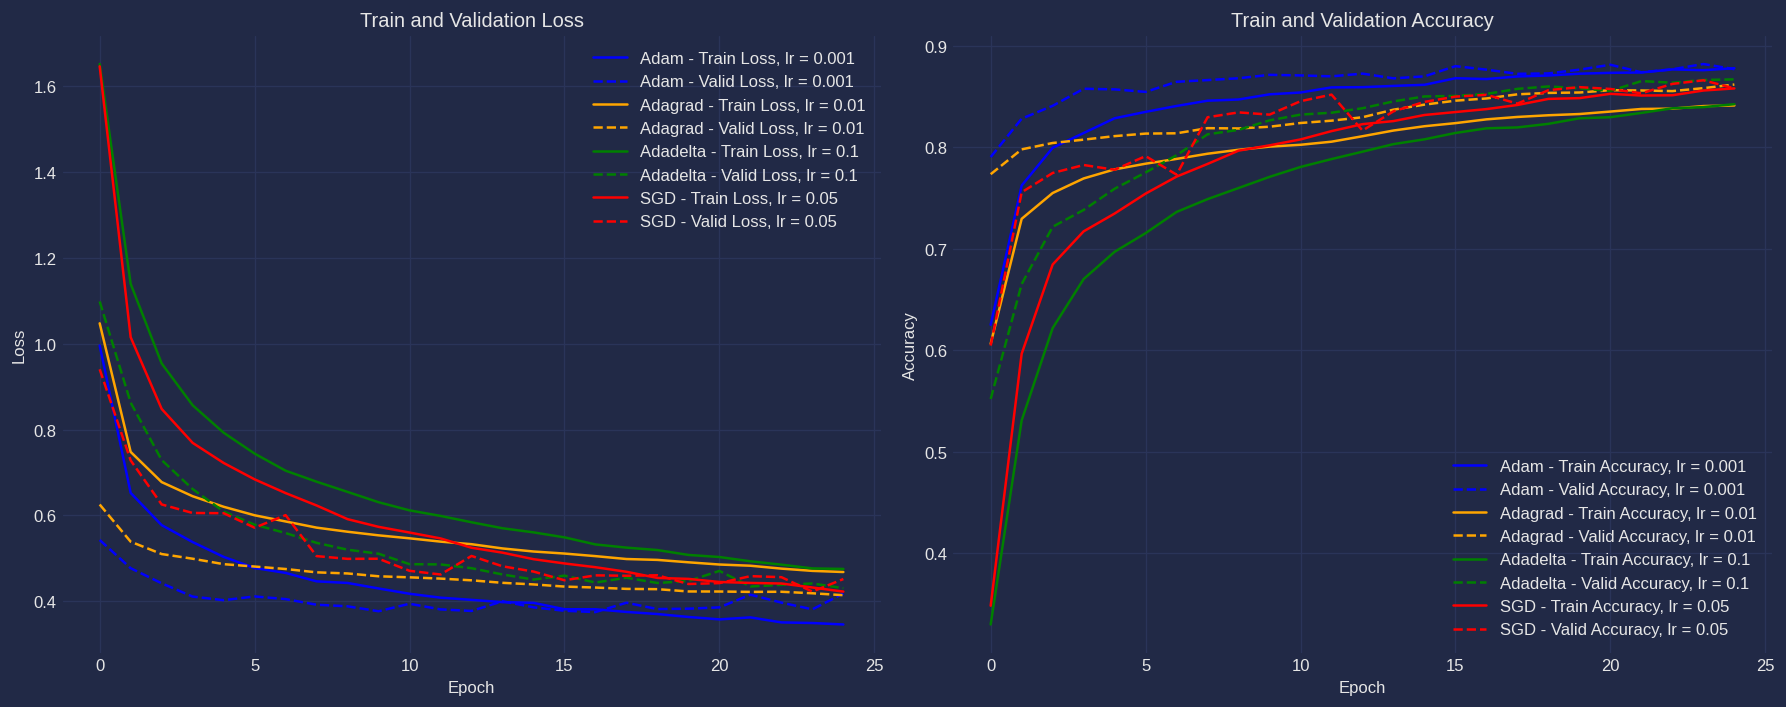

In [42]:
# Построение графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График слева: Лосс
ax1.plot(train_losses_adam, label="Adam - Train Loss, lr = 0.001", color='blue')
ax1.plot(valid_losses_adam, label="Adam - Valid Loss, lr = 0.001", linestyle='--', color='blue')

ax1.plot(train_losses_adag, label="Adagrad - Train Loss, lr = 0.01", color='orange')
ax1.plot(valid_losses_adag, label="Adagrad - Valid Loss, lr = 0.01", linestyle='--', color='orange')

ax1.plot(train_losses_adad, label="Adadelta - Train Loss, lr = 0.1", color='green')
ax1.plot(valid_losses_adad, label="Adadelta - Valid Loss, lr = 0.1", linestyle='--', color='green')

ax1.plot(train_losses_sgd, label="SGD - Train Loss, lr = 0.05", color='red')
ax1.plot(valid_losses_sgd, label="SGD - Valid Loss, lr = 0.05", linestyle='--', color='red')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Validation Loss')
ax1.legend()

# График справа: Точность
ax2.plot(train_metric_adam, label="Adam - Train Accuracy, lr = 0.001", color='blue')
ax2.plot(valid_metric_adam, label="Adam - Valid Accuracy, lr = 0.001", linestyle='--', color='blue')

ax2.plot(train_metric_adag, label="Adagrad - Train Accuracy, lr = 0.01", color='orange')
ax2.plot(valid_metric_adag, label="Adagrad - Valid Accuracy, lr = 0.01", linestyle='--', color='orange')

ax2.plot(train_metric_adad, label="Adadelta - Train Accuracy, lr = 0.1", color='green')
ax2.plot(valid_metric_adad, label="Adadelta - Valid Accuracy, lr = 0.1", linestyle='--', color='green')

ax2.plot(train_metric_sgd, label="SGD - Train Accuracy, lr = 0.05", color='red')
ax2.plot(valid_metric_sgd, label="SGD - Valid Accuracy, lr = 0.05", linestyle='--', color='red')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

### 🎓 Реализуй архитектуру, представленную ниже, и сравни ее эффективность с обученными выше моделями. 
Такое можно сделать только с помощью разработки класса модели, обычный sequential-подход тут не поможет. 


<img src="aux/imgs/simple_skip_con.png" height=500>